# Air Transportation Network Prediction Using GraphStorm

This notebook provides end-to-end training and inference pipelines for the air transportation network prediction whose data are generated using the `Synthetic_Airport_Traffic_wAirlines.ipynb` and `Air_Traffic_Data_Exp&Gc.ipynb` notebooks. Please run them first to create the synthetic data and store it at the `./gs_1p` folder.

For this synthetic air transportation network data, we define the prediction task as a node time series regression, i.e., predicting the total inventory amount.

Users may find that the end-to-end training/inference pipelines in this notebook are similar as the [Notebook 1: Use GraphStorm APIs for Building a Node Classification Pipeline](https://graphstorm.readthedocs.io/en/latest/api/notebooks/Notebook_1_NC_Pipeline.html). This notebook, however, has three major differences from the [Notebook 1](https://graphstorm.readthedocs.io/en/latest/api/notebooks/Notebook_1_NC_Pipeline.html) API example, including:

1. A customized RGCN model that can use sliding window method to process time series data for the regression task;
2. A customized node trainer class that can handle the specific evaluation method for time series data;
3. A customized node inferrer class that can handle the autoagressive sliding window method during model inference.

In [1]:
# Setup log level in Jupyter Notebook to show running information
import logging
logging.basicConfig(level=20)

---

### 0. Initialize the GraphStorm Standalone Environment

The first step to call `gs.initialize()` for using GraphStorm Standalone mode.

In [2]:
# Define the total days, should be same as data generation
NUM_DEMAND_DAYS = 31

# initialization
import graphstorm as gs
gs.initialize()

/opt/conda/envs/gsf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Setup GraphStorm Dataset and DataLoaders

Similar as PyTorch model training pipeline, we create a dataset by constructing `gs.dataset.GSgnnData` class. In most cases, users only need to provide the location of the graph description JSON file, which is created in GraphStorm's gconstruct operation.

In [3]:
# create a GraphStorm Dataset for the air transportation graph data
from graphstorm.dataloading import GSgnnData

ml_data = GSgnnData(part_config='./gs_1p/air_traffic.json')

INFO:root:Start to load partition from ./gs_1p/part0/graph.dgl which is 4831040 bytes. It may take non-trivial time for large partition.
INFO:root:Finished loading partition.
INFO:root:Finished loading node data.
INFO:root:Finished loading edge data.


Then, we create different `DataLoader`s for training, validation, and testing. As shown below, we allow users to specify different `DataLoader` settings, e.g., `fanout`, `batch_size`, except for a few model-related properties, such as `node_feats`, `edge_feats` and `label_field`.

GNN models may only use parts of graph features, therefore, GraphStorm `DataLoader`s allow users to specifies the `node_feats` and `edge_feats` in a format of a dictionary of lists of strings. Keys of the dictionary are node/edge type names, while values are lists of feature name strings.

In [4]:
# define dataloaders for training, validation, and testing
nfeats_4_modeling = {'airport':['latitude','longitude', 'inventory_amounts']}
efeats_4_modeling = {('airport', 'demand', 'airport'): ['demands'], \
                     ('airport', 'traffic', 'airport'): ['capacity', 'traffics']}

In our synthetic air transportation network, we have both node features and edge features.

In [5]:
from graphstorm.dataloading import GSgnnNodeDataLoader

fanout=[10, 10]
train_dataloader = GSgnnNodeDataLoader(
    dataset=ml_data,
    target_idx=ml_data.get_node_train_set(ntypes=['airport']),
    node_feats=nfeats_4_modeling,
    edge_feats=efeats_4_modeling,
    label_field='inventory_amounts',
    fanout=fanout,
    batch_size=64,
    train_task=True)
val_dataloader = GSgnnNodeDataLoader(
    dataset=ml_data,
    target_idx=ml_data.get_node_val_set(ntypes=['airport']),
    node_feats=nfeats_4_modeling,
    edge_feats=efeats_4_modeling,
    label_field='inventory_amounts',
    fanout=fanout,
    batch_size=64,
    train_task=False)
test_dataloader = GSgnnNodeDataLoader(
    dataset=ml_data,
    target_idx=ml_data.get_node_test_set(ntypes=['airport']),
    node_feats=nfeats_4_modeling,
    edge_feats=efeats_4_modeling,
    label_field='inventory_amounts',
    fanout=fanout,
    batch_size=64,
    train_task=False)

INFO:root:part 0, train 320
INFO:root:part 0, val 40
INFO:root:part 0, test 40


### 2. Create a Customized GraphStorm-compatible RGCN Model for the Time Series Node Regression

GraphStorm has a set of GNN component modules that could be freely combined for different tasks. This notebook depends on an RGCN model, `RgcnNRModel4TS`, that extends from the `GSgnnModel` and implements the sliding window method in its `forward()` and `predict()` functions for node regression by using GaphStorm APIs. Users can find the details of the `RgcnNRModel4TS` in the `nr_models.py` file.

Because our synthetic air transportation network have both static features and time series features, the customized `RgcnNRModel4TS` need to know which features are static or time series. So the `RgcnNRModel4TS` class asks this information in its arguments.

In [6]:
from nr_models import RgcnNRModel4TS

# initialize the model with specific time series related arugments
ts_nfeat_names = {'airport':['inventory_amounts']}
ts_efeat_names = {('airport', 'demand', 'airport'): ['demands'], \
                  ('airport', 'traffic', 'airport'): ['traffics']}

# import a customized RGCN model for node time series regression
model = RgcnNRModel4TS(g=ml_data.g,
                       num_hid_layers=len(fanout),
                       node_feat_field=nfeats_4_modeling,
                       edge_feat_field=efeats_4_modeling,
                       edge_feat_mp_op='add',
                       target_ntype='airport',
                       ts_nfeat_names=ts_nfeat_names,
                       ts_efeat_names=ts_efeat_names,
                       hid_size=128,
                       ts_size=NUM_DEMAND_DAYS,
                       window_size=7)

### 3. Setup a GraphStorm Evaluator

To check the performance during model training, GraphStorm relies on a set of built-in `Evaluator`s for different tasks. Here we use a built-in `graphstorm.eval.GSgnnRegressionEvaluator` for the node time series regression task.

In [7]:
# setup a regression evaluator for the trainer
from graphstorm.eval import GSgnnRegressionEvaluator

evaluator = GSgnnRegressionEvaluator(eval_frequency=1000)

### 4. Setup a Trainer and Training

For training loop, GraphStorm has different `Trainer`s for specific tasks. GraphStorm's `GSgnnNodePredictionTrainer` is designed to orchestrate dataloaders, models, and evaluators, but cannot handle the sliding window method. So here we extends the `GSgnnNodePredictionTrainer`, replacing its default `node_mini_batch_gnn_predict()` method with a customized method that supports sliding window for model training and validation, and autoregressive sliding window for testing. Users can find the details in the `nr_models.py` file.

Then we use the custom trainer's `fit()` function to train our model. During training, users can check the output log, finding training loss, evaluation metrics, and etc.

In [8]:
from nr_models import NodePredictionTrainer4TS

# define a trainer, which is our own custom trainer
trainer = NodePredictionTrainer4TS(model)

trainer.setup_evaluator(evaluator)
trainer.setup_device(gs.utils.get_device())

# Train the model with the trainer using fit() function
trainer.fit(train_loader=train_dataloader,
            val_loader=val_dataloader,
            test_loader=test_dataloader,
            num_epochs=200,
            save_model_frequency=1000,
            save_model_path='./models/')

INFO:root:Part 0 | Epoch 00000 | Batch 000 | Loss: 13875602.0000 | Time: 0.7426
INFO:root:Epoch 0 take 1.666 seconds
INFO:root:Step 5 | Validation rmse: 9039.9648
INFO:root:Step 5 | Test rmse: 8626.5488
INFO:root:Step 5 | Best Validation rmse: 9039.9648
INFO:root:Step 5 | Best Test rmse: 8626.5488
INFO:root:Step 5 | Best Iteration rmse: 5.0000
INFO:root: Eval time: 0.3250, Evaluation step: 5.
INFO:root:successfully save the model to ./models/epoch-0
INFO:root:Time on save model: 0.004 seconds
INFO:root:Part 0 | Epoch 00001 | Batch 000 | Loss: 76894848.0000 | Time: 0.2369
INFO:root:Epoch 1 take 1.161 seconds
INFO:root:Step 10 | Validation rmse: 537.0781
INFO:root:Step 10 | Test rmse: 510.0317
INFO:root:Step 10 | Best Validation rmse: 537.0781
INFO:root:Step 10 | Best Test rmse: 510.0317
INFO:root:Step 10 | Best Iteration rmse: 10.0000
INFO:root: Eval time: 0.3157, Evaluation step: 10.
INFO:root:successfully save the model to ./models/epoch-1
INFO:root:Time on save model: 0.003 seconds
I

### 5. Visualize Model Performance History

Besides the log, we can examine the model performance on the validation and testing sets by visualizing evalutors' history properties.

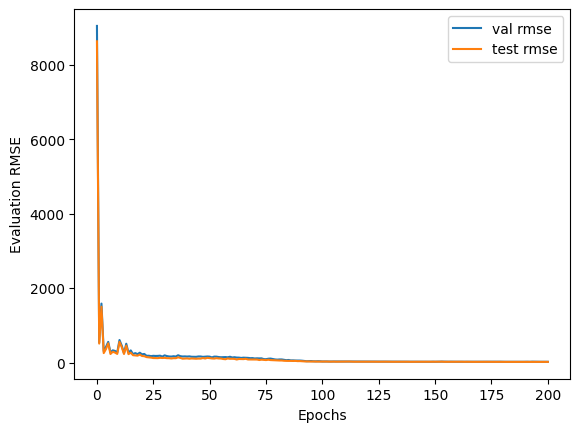

In [9]:
import matplotlib.pyplot as plt

# extract evaluation history of metrics from the evaluator's history property
val_metrics, test_metrics = [], []
for val_metric, test_metric in trainer.evaluator.history:
    val_metrics.append(val_metric['rmse'])
    test_metrics.append(test_metric['rmse'])

# plot the performance curves
fig, ax = plt.subplots()
ax.plot(val_metrics, label='val rmse')
ax.plot(test_metrics, label='test rmse')
ax.set(xlabel='Epochs', ylabel='Evaluation RMSE')
ax.legend(loc='best')

### 6. Inference with a Trained Model

GraphStorm automatically saves the best performed model(s) according to the validation values. The path to the best model can be acquired through a trainer's `get_best_model_path` function. We can first find out which checkpoint is the best model and its path. And then restore it by using model's `restore_model()` method.

In [10]:
# after training, the best model is saved to disk
best_model_path = trainer.get_best_model_path()
print('Best model path:', best_model_path)

# we can restore the model from the saved path using restore_model() function.
model.restore_model(best_model_path)

/opt/conda/envs/gsf/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
INFO:root:successfully load the model from ./models/epoch-183
INFO:root:Time on load model: 0.005 seconds


Best model path: ./models/epoch-183


To do inference, users can either create a new dataloader as the following code does, or reuse one of the dataloaders defined in training.

In [11]:
# Setup dataloader for inference
print(f'========================== Do Inference ================================')
infer_dataloader = GSgnnNodeDataLoader(
    dataset=ml_data,
    target_idx=ml_data.get_node_infer_set(ntypes='airport', mask=None),
    node_feats=nfeats_4_modeling,
    edge_feats=efeats_4_modeling,
    label_field='inventory_amounts',
    fanout=fanout,
    batch_size=64,
    train_task=False)

INFO:root:airport does not contains NoneWe will do inference on the entire node set.


========================== Do Inference ================================


GraphStorm provides a set of `Inferrer`s that can perform highly efficient inference for very large graphs. However, GraphStorm's `GSgnnNodePredictionInferrer` cannot handle the sliding window mehtod either. Similarly we extends the `GSgnnNodePredictionInferrer` to specifically implement the autoregressive sliding window method by replacing true time serie values with the predicted ones, and then call the same customized `node_mini_batch_gnn_predict()` method during inference. Users can find the details in the `nr_models.py` file.

In [12]:
from nr_models import NodePredictionInferrer4TS

# Run inference on the inference dataset
infer = NodePredictionInferrer4TS(model)

infer.infer(infer_dataloader,
            use_mini_batch_infer=True,
            save_embed_path=None,
            init_step=0,
            infer_steps=7,
            node_id_mapping_file='./gs_1p/node_mapping.pt',
            save_prediction_path='./predictions')

Now let's check the prediction results

In [13]:
# The prediction results on the inference graph are saved to the folder named after the target_ntype
!ls -lh ./predictions/airport/

total 24K
-rw-rw-r-- 1 ubuntu ubuntu  13K Jan 25 01:12 predict-00000.pt
-rw-rw-r-- 1 ubuntu ubuntu 4.4K Jan 25 01:12 predict_nids-00000.pt


In [14]:
import torch as th
import pandas as pd

#### Prediction results exploration

The prediction results are two Pytorch tensor files. One is the actual prediction values, and another is the GraphStorm node ID file.

In [15]:
pred_th = th.load('./predictions/airport/predict-00000.pt')
pred_th.shape

torch.Size([400, 7])

The `predict-00000.pt` file stores the prediction results, which are in a $N \times 7 $ tensor, where $N$ is the number of all airports, and $7$ is the total steps to predict.

As we set the `init_step=0` and `infer_steps=7` in the above `infer()` function, it will start from the step 0 and use values defined in `window_size`, i.e. from step 0 to step 6, to predict the 7th step values, and then repeat this inference operation 7 times to obtain the prediction values from step 7 to step 14.

In [16]:
pred_nid_th = th.load('./predictions/airport/predict_nids-00000.pt')
pred_nid_th.shape

torch.Size([400])

The `predict_nids-00000.pt` file stores the GraphStorm node IDs, ranging from 0 to the total number of nodes minus 1. The ID tensor has the same order as the predictions, therefore can be used for raw ID mapping.

----
#### Node ID mapping file

In [17]:
raw_nid_mapping = pd.read_parquet('./gs_1p/raw_id_mappings/airport/part-00000.parquet')
raw_nid_mapping.head(1)

,orig,new
0,HIR,0


The synthetic airport node table use airport iata codes as node IDs. GraphStorm graph construction command convert them into the integer-based IDs. So we can use all three files to remap the prediction values to the original iata codes.

In [18]:
pred_df = pd.DataFrame({
    'new': pred_nid_th.numpy(),
    'prediction': pred_th.numpy().tolist()
})

In [19]:
final_pred_df = pd.merge(raw_nid_mapping, pred_df, on='new')
final_pred_df.sample(4)

,orig,new,prediction
291,DWC,291,"[346.7327880859375, 429.61993408203125, 528.47..."
316,MWX,316,"[340.53924560546875, 415.79815673828125, 517.0..."
138,MEM,138,"[573.6900634765625, 718.2579956054688, 811.019..."
283,MHD,283,"[385.9654541015625, 482.9989013671875, 572.409..."
